# CSC/XMM validation catalogs

In [142]:
import sys
sys.path.append('../')

matplotlib settings set


In [143]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


***

In [144]:
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') 
ero_df.sample(5)

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
9024,SRGe J103416.1+552601,158.567078,55.433506,154.554699,52.434856,69.324348,6.680357,2.999891e-15,1.670606e-15,14.212394,7.914724,4328.218750,0.0,0.0,0.0,6798,5694,158.569087,55.432216,31.014025,55.374355,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.003284,0.001829,17.082548,158.567078,55.433506,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,17.410999,17.065001,12.530,7.8,1.0,0.5,1,0,-1,0,0,NaN,72786340369,31.014025,24.783924,37.413616,60.664768,135.567348,42.302896,2.308533e-15,7.469781e+19
6611,SRGe J102904.1+563353,157.267004,56.564652,153.711524,51.195400,8.134188,13.636163,5.087472e-15,1.426636e-15,24.408852,6.844763,4383.215332,0.0,0.0,0.0,6475,5391,157.269012,56.563363,3.538316,119.946053,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.005569,0.001562,19.486040,157.267004,56.564652,854611802284435712,9.908013,1,0,20.06599,-1.0,0,SDSS J102904.07+563357.3,1.947,QSO,9.919617,1,0,0,1,16.645000,15.412000,12.554,14.6,12.2,2.6,1,3,0,1237655107834610347,0,2.475402,68234782706,3.538316,2.908027,4.389935,7.118114,133.942652,42.917877,3.915008e-15,6.066684e+19
5054,SRGe J103332.7+591223,158.386251,59.206262,149.795856,50.113226,9.691114,8.894165,6.779548e-15,2.240654e-15,20.488478,6.771482,2760.936768,0.0,0.0,0.0,5786,4762,158.388260,59.204973,4.251879,50.738457,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.007421,0.002453,40.311924,158.386251,59.206262,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,1,17.047001,15.969000,12.244,11.4,8.3,1.2,1,1,0,1237655369282289891,0,3.731437,58130229507,4.251879,3.464639,5.230192,8.480559,132.759524,45.489397,5.217126e-15,8.596427e+19
4795,SRGe J103349.3+584441,158.455573,58.744828,150.329874,50.425786,6.972946,25.894224,7.167526e-15,1.803166e-15,30.076790,7.566548,3833.625488,0.0,0.0,0.0,4861,3948,158.457581,58.743538,3.000976,136.819046,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.007846,0.001974,16.705593,158.455573,58.744828,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,59841351744,3.000976,2.492876,3.763226,6.101928,133.147745,45.115716,5.515691e-15,6.650525e+19
8346,SRGe J104707.2+593731,161.780049,59.625236,147.523914,51.152626,11.203570,6.250158,3.711331e-15,1.377323e-15,17.575346,6.522439,4326.350098,0.0,0.0,0.0,8374,7227,161.782058,59.623947,4.940479,100.088364,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.004062,0.001508,28.810003,161.780049,59.625236,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1237653616934453565,0,9.765337,56596575626,4.940479,4.005352,6.046449,9.804089,134.530932,46.773876,2.856014e-15,8.408972e+19


In [145]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03



def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r




r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
2230779,9011,2520,605980,156.177661,56.213336,0.350075,0.648166,1.127854,2.466401,0.667933,9.595240,-51.881226,244.73148,90.190310,26.920359,4.354825,1.061889,0.001476,0.000018,23.608791,22.950031,22.357760,21.518078,22.937086,20.044630,NaN,5.476530,6.155542,5.851853,5.146940,0.688291,0.368600,-0.221575,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.262110,57784.426510,2018-04-18 06:17:26.310,2017-01-31 10:14:10.489,9011_605980_2520
2225855,9011,1127,605177,157.414096,56.000832,0.551784,0.504314,1.613809,8.364134,10.165670,64.747345,-210.852630,194.33908,56.401066,21.219612,4.060914,1.027551,0.001379,0.000017,23.127485,23.231060,21.973553,20.192911,19.981524,17.971810,NaN,7.692177,3.787430,7.433969,16.855158,10.304754,2.404657,-0.878760,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57894.184261,57784.426510,2017-05-21 04:25:20.130,2017-01-31 10:14:10.489,9011_605177_1127
1209341,9011,2535,610717,159.339091,57.731532,0.980475,2.127730,3.292112,5.193325,5.400596,-34.919266,230.781810,411.15350,117.652664,64.962560,3.971006,1.065395,0.001564,0.000019,22.504045,21.668512,21.199772,20.710392,20.668285,NaN,16.591948,19.881023,23.079018,26.534214,10.348938,5.574387,-1.381157,1.013471,EXP,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.395665,57464.292477,2018-03-17 09:29:45.430,2016-03-17 07:01:10.000,9011_610717_2535
1544663,9011,130,606799,163.771615,56.573581,0.264634,0.264308,0.290915,1.097017,2.427499,34.456530,677.143740,543.17004,240.173260,105.138750,4.891448,1.154626,0.001288,0.000016,23.916230,23.926430,23.830353,22.397911,21.536148,18.656618,15.423221,6.167563,4.096127,2.982957,2.426231,2.608433,1.236408,2.680547,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.410133,57784.435198,2018-03-17 09:50:35.462,2017-01-31 10:26:41.119,9011_606799_130
1386350,9011,2428,608377,159.742892,57.037271,0.453275,0.547338,0.640275,-2.058390,-0.455600,40.983830,-363.342200,362.54434,134.135150,87.365326,4.290552,1.102214,0.001184,0.000015,23.335932,23.138758,22.975355,NaN,NaN,18.468294,NaN,8.630617,6.339089,5.984611,-4.263676,-0.478318,1.410024,-1.386445,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.397094,57464.293866,2018-03-17 09:31:48.949,2016-03-17 07:03:10.000,9011_608377_2428


# CSC

In [146]:
csc_df = pd.read_pickle(data_path+'csc_all_lh.pkl')
csc_df.sample(5)

,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,radec_err,r_98,flux_05_2,flux_05_2_err,secure
127487,2CXO J105752.6+564016,164.469337,56.671149,8.333824,5.455677,52.597486,2.666667,14.714585,MARGINAL,False,False,False,False,False,False,True,0.000000e+00,0.000000e+00,2.118118e-15,4.486842e-15,2.125346e-15,6.730264e-15,4.069365,11.382622,4.486842e-15,3.885361e-15,True
114682,2CXO J103338.0+575802,158.408634,57.967233,0.803907,0.753080,173.179612,4.971429,110.866673,TRUE,False,False,False,False,False,False,False,1.283038e-15,8.553587e-16,1.688208e-15,1.999681e-15,1.538216e-15,2.435509e-15,0.450023,1.258781,3.282719e-15,8.660070e-16,True
122893,2CXO J104607.6+585602,161.531952,58.934040,1.365973,1.365973,0.000000,3.352941,31.295554,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,1.461822e-16,2.195238e-16,4.621553e-17,3.812781e-16,0.789207,2.207529,2.195238e-16,2.785129e-16,True
126192,2CXO J105033.3+580003,162.638914,58.000957,2.124228,2.124226,0.000000,1.837838,83.703189,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,6.153263e-15,0.000000e+00,0.000000e+00,3.455186e-15,1.227296,3.432931,0.000000e+00,7.056979e-15,True
114762,2CXO J103403.0+582639,158.512717,58.444197,6.246699,3.981509,40.939788,3.937500,31.765209,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,4.366053e-15,8.683219e-15,5.734202e-15,1.146840e-14,3.026324,8.465082,8.683219e-15,5.959561e-15,True


## CSC x ERO cross-match

In [147]:
ero_csc_orig = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc_orig.query("csc_n_near==1 & csc_n_matches==1")

ero_csc = ero_csc.query("csc_secure==True")
print('SECURITY FILTER APPLIED (CSC)')
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])
assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 941 out of 9215 x 2329
	 total unique pairs: 868
	 total non-unique pairs (duplicates in df2): 73
SECURITY FILTER APPLIED (CSC)
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 555


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_radec_err,csc_r_98,csc_flux_05_2,csc_flux_05_2_err,csc_secure,csc_sep,csc_n_near,csc_n_matches
161,SRGe J103319.6+575810,158.331822,57.969366,151.363049,50.845507,3.908558,136.618042,2.213911e-14,2.538248e-15,103.227684,11.835052,4259.744629,0.0,0.0,0.0,1137,916,158.333830,57.968077,1.525419,99.704117,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.024233,0.002778,17.763712,158.331822,57.969366,855020687466884224,7.043658,1,0,20.583292,-1.0,0,2XMM J103319.4+575808,1.051000,AGN,7.049247,1,1,0,0,16.759001,16.103001,12.372,14.3,7.3,1.1,1,1,0,1237658304352354589,0,7.166189,62769162646,1.525419,1.397336,2.109407,3.420324,133.638686,44.419962,1.703691e-14,5.722184e+19,2CXO J103319.3+575809,158.330712,57.969249,0.746167,0.729957,159.212001,7.504062,396.060649,TRUE,False,False,False,False,False,False,False,5.899690e-15,4.706494e-15,7.026597e-15,3.650715e-15,2.804818e-15,4.496613e-15,0.426449,1.192843,9.550405e-15,2.030941e-15,True,2.161475,1,1
48,SRGe J105156.7+565306,162.986109,56.885122,150.134330,53.468981,3.010595,424.502655,5.291392e-14,3.778653e-15,244.870316,17.486509,4227.792480,0.0,0.0,0.0,332,281,162.988117,56.883833,1.040398,110.276237,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.057919,0.004136,21.616272,162.986109,56.885122,851162977905592704,6.243657,1,0,20.968739,-1.0,0,NaN,NaN,NaN,-1.000000,0,1,0,0,15.773000,15.137000,12.702,24.1,14.4,2.1,1,1,0,1237655106762179004,7987354228082626560,6.254224,66969181695,1.040398,1.076308,1.624786,2.634529,137.432511,44.819454,4.071933e-14,6.886800e+19,2CXO J105156.7+565306,162.986574,56.885136,1.875034,1.473617,50.508828,4.315789,67.314812,TRUE,False,False,False,False,False,False,False,1.086549e-14,5.432746e-15,1.602660e-14,6.970942e-15,3.659744e-15,1.028214e-14,0.974286,2.725224,1.783643e-14,8.836279e-15,True,0.915993,1,1
573,SRGe J105302.4+573758,163.259801,57.632862,149.044304,53.073864,6.903723,19.078884,6.723091e-15,1.636160e-15,31.813745,7.742331,4323.080566,0.0,0.0,0.0,5639,4635,163.261810,57.631573,2.968746,134.703964,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.007359,0.001791,20.686918,163.259801,57.632862,-1,-1.000000,0,-1,NaN,-1.0,-1,2XMM J105302.4+573756,1.885580,Seyfert_1,4.641915,1,1,1,0,17.493000,16.995001,12.762,7.9,1.4,0.2,1,1,1,1237658302742790493,9215494160714584064,4.639355,64059772633,2.968746,2.468128,3.725867,6.041352,137.036480,45.528738,5.173681e-15,6.943349e+19,2CXO J105302.4+573756,163.260051,57.632470,0.884681,0.791848,74.000190,15.202441,794.057273,TRUE,False,False,False,False,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,0.485059,1.356782,NaN,NaN,True,1.491775,1,1
699,SRGe J105631.0+573708,164.129230,57.618848,148.525287,53.420950,8.577944,15.339711,5.543155e-15,1.553459e-15,23.670603,6.633646,3901.214355,0.0,0.0,0.0,6843,5738,164.131239,57.617558,3.742340,146.245331,0.000010,6.268413e+08,6.270701e+08,0.0,0.0,0.006067,0.001700,15.900247,164.129230,57.618848,857194043997898624,5.208768,1,0,20.917603,-1.0,0,SDSS J105631.43+573708.4,1.517782,QSO,5.207920,1,1,0,1,15.901000,14.730000,12.515,21.0,19.7,2.8,1,1,1,1237655107299377295,9207795380246564864,5.221720,64113476299,3.742340,3.0

## CSC x DESI cross-match

In [148]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2509 out of 555 x 2418574
	 total unique pairs: 2509
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_radec_err,csc_r_98,csc_flux_05_2,csc_flux_05_2_err,csc_secure,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,True,2.779278,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.07499,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,True,2.779278,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544262,-131.121550,-1138.750900,749.9

In [149]:
csc_desi = csc_desi_all.query("desi_sep<=1.1*csc_r_98") #of you want only sep < r_false and the only one, replace 1.1*csc_r_98 with @r_false
#desi within 1.1*csc_r_98 and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]


#csc_desi = csc_desi_all.query("desi_sep<=@r_false")
csc_desi = csc_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 366


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_radec_err,csc_r_98,csc_flux_05_2,csc_flux_05_2_err,csc_secure,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
1098,SRGe J104850.0+571006,162.208538,57.168301,150.248365,52.964389,5.917938,40.364368,9.604319e-15,1.817933e-15,43.983997,8.325417,4183.845215,0.0,0.0,0.0,3474,2764,162.210547,57.167011,2.506354,175.908646,0.000010,6.268413e+08,6.270701e+08,0.0,0.0,0.010513,0.001990,17.300806,162.208538,57.168301,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,1,16.867001,15.857000,12.319,12.9,9.1,1.7,1,0,-1,0,0,NaN,65860508305,2.506354,2.115703,3.193849,5.178705,136.714807,44.832193,7.390899e-15,6.904034e+19,2CXO J104850.0+571001,162.208493,57.166948,1.118389,0.901395,44.250981,2.666667,24.990075,TRUE,False,False,False,False,False,False,False,1.788930e-14,4.293433e-15,3.148517e-14,6.173067e-15,3.086534e-15,9.097152e-15,0.586834,1.641463,2.406237e-14,1.969194e-14,True,4.868917,1,1,9011,1394,609168,162.208550,57.166924,0.496220,1.048614,1.387818,8.934950,13.730731,21.606785,633.30620,414.70712,151.868450,97.04911,4.133359,0.995247,0.001377,0.000016,23.240906,22.435051,22.136667,20.121130,19.655066,19.163376,15.495910,10.105208,12.922589,13.671881,18.165346,13.698059,0.801717,2.562443,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.405780,57784.444599,2018-03-17 09:44:19.410,2017-01-31 10:40:13.339,9011_609168_1394,0.142267,5,1,3.255676
935,SRGe J104530.3+585238,161.376187,58.877161,148.631784,51.503388,5.463918,51.152950,1.105122e-14,1.920545e-15,51.505756,8.950967,4257.875488,0.0,0.0,0.0,2976,2369,161.378196,58.875871,2.290580,176.957397,0.000010,6.268413e+08,6.270701e+08,0.0,0.0,0.012097,0.002102,17.652958,161.376187,58.877161,-1,-1.000000,0,-1,NaN,-1.0,-1,[VV2010c] J104530.2+585237,1.930,AGN,6.949180,2,1,1,1,17.525000,16.503000,12.759,6.8,4.6,-0.8,1,2,1,1237655109446468373,0,6.013652,59348357641,2.290580,1.953388,2.948819,4.781399,134.874097,46.034786,8.504346e-15,7.945389e+19,2CXO J104530.1+585237,161.375489,58.877131,1.788983,1.328245,175.243105,7.202359,170.389574,TRUE,False,False,False,False,False,False,False,2.973523e-15,2.116745e-15,3.779902e-15,3.508356e-15,2.814396e-15,4.163764e-15,0.910290,2.546217,6.481879e-15,1.515076e-15,True,1.303902,1,1,9011,1457,614516,161.375592,58.876755,0.240050,0.281550,0.457715,6.064075,6.612358,0.769204,-402.08997,641.48500,235.702510,104.68859,4.626911,1.130004,0.001136,0.000014,24.025837,23.86034

***

# 4XMM DR10

In [150]:
xmm_df = pd.read_pickle(data_path+'xmm_all_lh.pkl')
xmm_df.sample(5)

,srcid,iauname,sc_ra,sc_dec,sc_poserr,sc_det_ml,sc_ep_1_flux,sc_ep_1_flux_err,sc_ep_2_flux,sc_ep_2_flux_err,sc_ep_3_flux,sc_ep_3_flux_err,sc_ep_4_flux,sc_ep_4_flux_err,sc_ep_5_flux,sc_ep_5_flux_err,sc_ep_8_flux,sc_ep_8_flux_err,sc_ep_9_flux,sc_ep_9_flux_err,sc_ep_8_fmin,sc_ep_8_fmin_err,sc_ep_8_fmax,sc_ep_8_fmax_err,sc_hr1,sc_hr1_err,sc_hr2,sc_hr2_err,sc_hr3,sc_hr3_err,sc_hr4,sc_hr4_err,sc_extent,sc_ext_err,sc_ext_ml,sc_chi2prob,sc_var_flag,sc_sum_flag,mjd_first,mjd_last,sc_fvar,sc_fvarerr,n_detections,confused,webpage_url,flux_05_2,flux_05_2_err,sigma,r_98,secure
255916,201475112010094,4XMM J105443.0+574040,163.679414,57.678007,1.760240,11.8977,1.518700e-17,3.185260e-16,1.884070e-15,8.559250e-16,2.020110e-16,5.251850e-16,7.153090e-15,2.930320e-15,8.011160e-15,1.457920e-14,1.911480e-14,1.501090e-14,7.783580e-15,2.230490e-15,1.911480e-14,1.501090e-14,1.911480e-14,1.501090e-14,0.997165,0.163102,-0.699524,0.367116,0.865914,0.293705,-0.201959,0.437386,0.0000,NaN,-0.569717,NaN,NaN,0,52572.339919,52573.543542,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20147511...,2.086081e-15,1.004205e-15,1.248270,3.491598,True
256634,206060301010087,4XMM J105741.6+574543,164.423407,57.762015,1.327020,10.5311,5.307170e-16,2.980280e-16,8.701650e-16,3.864560e-16,1.829240e-15,6.355380e-16,3.967630e-15,1.703570e-15,9.626790e-15,1.132190e-14,1.807330e-14,1.157380e-14,6.273730e-15,1.351170e-15,8.396740e-15,1.427420e-14,3.664410e-14,1.977450e-14,0.196091,0.231159,0.410109,0.193275,-0.240735,0.229914,0.291888,0.329300,0.0000,NaN,-0.525005,NaN,NaN,0,55121.968056,55297.794479,NaN,NaN,2,False,http://xmm-catalog.irap.omp.eu/source/20606030...,2.699405e-15,7.438123e-16,0.941053,2.632267,True
255819,201475111015087,4XMM J105422.2+573644,163.592519,57.612231,0.719651,47.3487,1.295960e-15,2.512030e-16,1.533210e-15,2.820180e-16,1.329710e-15,2.870540e-16,4.976920e-16,4.385610e-16,1.330630e-15,2.298460e-15,8.932470e-15,2.586940e-15,4.966040e-15,6.873400e-16,7.163070e-15,3.843040e-15,1.089680e-14,4.255340e-15,0.080413,0.102286,-0.071332,0.110420,-0.722595,0.138393,0.670448,0.239800,0.0000,NaN,0.492909,NaN,NaN,1,52570.341921,52575.215278,NaN,NaN,3,False,http://xmm-catalog.irap.omp.eu/source/20147511...,2.862920e-15,4.024104e-16,0.510339,1.427494,True
249745,208223909010019,4XMM J104142.1+574237,160.425699,57.710356,1.156200,53.6974,6.022860e-16,4.321210e-16,1.550690e-16,3.040430e-16,3.166900e-16,3.841690e-16,1.309780e-14,2.626570e-15,2.942860e-14,9.379500e-15,4.682870e-14,9.975020e-15,8.385010e-15,1.642140e-15,4.682870e-14,9.975020e-15,4.682870e-14,9.975020e-15,-0.627299,0.593472,0.811057,0.390160,0.856867,0.124912,-0.221420,0.144564,0.0000,NaN,-1.122370,NaN,NaN,0,58441.381088,58441.542685,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20822390...,4.717590e-16,4.899265e-16,0.819917,2.293429,True
251627,205541213010111,4XMM J104509.0+585141,161.287610,58.861453,8.555920,18.8314,1.068230e-16,4.290740e-16,2.445190e-16,4.398160e-16,1.482140e-15,1.202910e-15,3.997810e-16,1.139640e-15,2.960680e-14,3.337140e-14,3.846790e-14,3.344380e-14,3.253700e-15,2.201090e-15,3.846790e-14,3.344380e-14,3.846790e-14,3.344380e-14,0.349754,0.158151,-0.362367,0.181000,-0.180961,0.384476,0.503195,0.281828,26.3612,3.57991,11.610200,0.16668,False,0,54780.798021,54781.372685,2.168357,1.657077,1,False,http://xmm-catalog.irap.omp.eu/source/20554121...,1.726659e-15,1.280793e-15,6.067411,16.971457,False


## XMM x eROSITA cross-match

In [151]:
ero_xmm_orig = cross_match_data_frames(ero_df, xmm_df,
 'RA_fin', 'DEC_fin', 'sc_ra', 'sc_dec', match_radius = 30, df_prefix = 'xmm')
 
ero_xmm = ero_xmm_orig.query("xmm_n_near==1 & xmm_n_matches==1")
ero_xmm = ero_xmm.query("xmm_secure==True")
print('SECURITY FILTER APPLIED (XMM)')

ero_xmm = ero_xmm.query("xmm_secure==True")
print('cross-matches: only one xmm within 30 arcsec and it is unique for the eROSITA source', ero_xmm.shape[0])
assert len(ero_xmm) == ero_xmm.xmm_srcid.nunique()
ero_xmm.sample(5)

cross-match radius 30 arcsec
total matches: 978 out of 9215 x 1791
	 total unique pairs: 944
	 total non-unique pairs (duplicates in df2): 34
SECURITY FILTER APPLIED (XMM)
cross-matches: only one xmm within 30 arcsec and it is unique for the eROSITA source 742


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,xmm_srcid,xmm_iauname,xmm_sc_ra,xmm_sc_dec,xmm_sc_poserr,xmm_sc_det_ml,xmm_sc_ep_1_flux,xmm_sc_ep_1_flux_err,xmm_sc_ep_2_flux,xmm_sc_ep_2_flux_err,xmm_sc_ep_3_flux,xmm_sc_ep_3_flux_err,xmm_sc_ep_4_flux,xmm_sc_ep_4_flux_err,xmm_sc_ep_5_flux,xmm_sc_ep_5_flux_err,xmm_sc_ep_8_flux,xmm_sc_ep_8_flux_err,xmm_sc_ep_9_flux,xmm_sc_ep_9_flux_err,xmm_sc_ep_8_fmin,xmm_sc_ep_8_fmin_err,xmm_sc_ep_8_fmax,xmm_sc_ep_8_fmax_err,xmm_sc_hr1,xmm_sc_hr1_err,xmm_sc_hr2,xmm_sc_hr2_err,xmm_sc_hr3,xmm_sc_hr3_err,xmm_sc_hr4,xmm_sc_hr4_err,xmm_sc_extent,xmm_sc_ext_err,xmm_sc_ext_ml,xmm_sc_chi2prob,xmm_sc_var_flag,xmm_sc_sum_flag,xmm_mjd_first,xmm_mjd_last,xmm_sc_fvar,xmm_sc_fvarerr,xmm_n_detections,xmm_confused,xmm_webpage_url,xmm_flux_05_2,xmm_flux_05_2_err,xmm_sigma,xmm_r_98,xmm_secure,xmm_sep,xmm_n_near,xmm_n_matches
243,SRGe J103426.5+601055,158.610301,60.181945,148.506912,49.589688,10.920171,13.233225,1.753125e-14,5.402529e-15,18.027266,5.555386,939.430359,0.0,0.0,0.0,7129,6011,158.612310,60.180655,4.811704,83.560829,0.000019,6.268413e+08,6.270701e+08,0.0,0.0,0.019190,0.005914,6.328879,158.610301,60.181945,1047948312004823296,1.822583,1,0,20.005226,-1.0,0,2XMM J103427.0+601051,0.811,QSO,1.827984,1,1,0,1,15.587000,14.722000,11.755,27.3,20.3,4.8,1,1,1,1237655370356228256,7981741221239607296,1.782922,54586666434,4.811704,3.904035,5.893501,9.556089,132.150589,46.375616,1.349098e-14,7.440836e+19,203060507010003,4XMM J103427.1+601052,158.612988,60.181133,0.646021,689.9760,1.966660e-14,1.985350e-15,1.707110e-14,1.915030e-15,1.772300e-14,2.147390e-15,2.202420e-14,4.107910e-15,3.397120e-14,1.719560e-14,1.118230e-13,1.822420e-14,6.368340e-14,4.714780e-15,1.118230e-13,1.822420e-14,1.118230e-13,1.822420e-14,-0.025472,0.072071,-0.065632,0.076124,-0.406242,0.092745,-0.322147,0.199007,0.0,NaN,-2.241700,0.320445,False,0,53464.316447,53464.431447,0.117673,0.207228,1,False,http://xmm-catalog.irap.omp.eu/source/20306050...,3.479410e-14,2.877260e-15,0.458124,1.281442,True,5.627130,1,1
359,SRGe J103450.7+601307,158.711422,60.218615,148.413944,49.605155,9.188740,9.375892,1.336941e-14,4.547504e-15,15.174969,5.161652,1036.962524,0.0,0.0,0.0,2690,2146,158.713431,60.217326,4.022275,63.001213,0.000018,6.268413e+08,6.270701e+08,0.0,0.0,0.014634,0.004978,5.730609,158.711422,60.218615,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,0,17.016001,17.493000,12.089,10.3,2.1,1.3,2,0,-1,0,0,NaN,54455901130,4.022275,3.285037,4.959066,8.040938,132.183480,46.433546,1.028828e-14,7.565745e+19,203060507010011,4XMM J103450.7+601315,158.711598,60.220953,0.931146,208.2510,3.490130e-15,1.250470e-15,1.660660e-14,2.492490e-15,1.760830e-14,2.886130e-15,1.741080e-14,5.997270e-15,9.201090e-14,3.628900e-14,1.506640e-13,3.702470e-14,6.298130e-14,6.477090e-15,1.506640e-13,3.702470e-14,1.506640e-13,3.702470e-14,0.546940,0.108503,-0.068227,0.109289,-0.448777,0.141443,0.109882,0.238871,0.0,NaN,-1.676040,0.250737,False,0,53464.316447,53464.431447,0.208941,0.304900,1,False,http://xmm-catalog.irap.omp.eu/source/20306050...,3.421490e-14,3.813431e-15,0.660320,1.847014,True,8.420626,1,1
963,SRGe J105309.1+572058,163.287759,57.349338,149.374059,53.277701,12.667942,6.295109,3.434480e-15,1.292862e-15,16.299364,6.135668,4335.679688,0.0,0.0,0.0,8907,7753,163.289768,57.348048,5.604470,85.722389,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.003759,0.001415,24.413029,163.287759,57.349338,-1,-1.000000,0,-1,NaN,-1.0,-1,[MBC2005] 86,3.420,AGN,4.911874,1,1,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,651

## XMM x DESI cross-match

In [152]:
xmm_desi_all = cross_match_data_frames(ero_xmm, desi, colname_ra1 = 'xmm_sc_ra',colname_dec1 = 'xmm_sc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
xmm_desi_all

cross-match radius 15 arcsec
total matches: 3293 out of 742 x 2418574
	 total unique pairs: 3293
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,xmm_srcid,xmm_iauname,xmm_sc_ra,xmm_sc_dec,xmm_sc_poserr,xmm_sc_det_ml,xmm_sc_ep_1_flux,xmm_sc_ep_1_flux_err,xmm_sc_ep_2_flux,xmm_sc_ep_2_flux_err,xmm_sc_ep_3_flux,xmm_sc_ep_3_flux_err,xmm_sc_ep_4_flux,xmm_sc_ep_4_flux_err,xmm_sc_ep_5_flux,xmm_sc_ep_5_flux_err,xmm_sc_ep_8_flux,xmm_sc_ep_8_flux_err,xmm_sc_ep_9_flux,xmm_sc_ep_9_flux_err,xmm_sc_ep_8_fmin,xmm_sc_ep_8_fmin_err,xmm_sc_ep_8_fmax,xmm_sc_ep_8_fmax_err,xmm_sc_hr1,xmm_sc_hr1_err,xmm_sc_hr2,xmm_sc_hr2_err,xmm_sc_hr3,xmm_sc_hr3_err,xmm_sc_hr4,xmm_sc_hr4_err,xmm_sc_extent,xmm_sc_ext_err,xmm_sc_ext_ml,xmm_sc_chi2prob,xmm_sc_var_flag,xmm_sc_sum_flag,xmm_mjd_first,xmm_mjd_last,xmm_sc_fvar,xmm_sc_fvarerr,xmm_n_detections,xmm_confused,xmm_webpage_url,xmm_flux_05_2,xmm_flux_05_2_err,xmm_sigma,xmm_r_98,xmm_secure,xmm_sep,xmm_n_near,xmm_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323629,58.824642,149.266632,51.126914,2.166339,3391.888916,2.361506e-13,7.471780e-15,1120.011108,35.437035,4332.920898,0.0,0.0,0.0,38,27,160.325638,58.823353,0.454968,97.643723,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.258489,0.008179,18.102430,160.323629,58.824642,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,1,0,15.243,15.129000,12.821,31.5,15.9,-0.2,1,3,0,1237658304889815429,0,2.181367,59543516327,0.454968,0.774481,1.169150,1.895733,134.256532,45.696772,1.817271e-13,7.704875e+19,205562112010003,4XMM J104117.9+584929,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,False,0,54595.266366,54595.352928,0.012697,1.426367,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,8.770400e-14,6.519681e-15,0.580060,1.622515,True,2.015272,1,1,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.365800,671.00964,212.87097,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31,9011_613766_43,0.975167,9,1
6,SRGe J104117.7+584929,160.323629,58.824642,149.266632,51.126914,2.166339,3391.888916,2.361506e-13,7.471780e-15,1120.011108,35.437035,4332.920898,0.0,0.0,0.0,38,27,160.325638,58.823353,0.454968,97.643723,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.258489,0.008179,18.102430,160.323629,58.824642,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,1,0,15.243,15.129000,12.821,31.5,15.9,-0.2,1,3,0,1237658304889815429,0,2.181367,59543516327,0.4549

In [153]:
xmm_desi = xmm_desi_all.query("desi_sep<=1.1*xmm_r_98") #of you want only sep < r_false and the only one, replace 1.1*xmm_r_98 with @r_false
#desi within 1.1*xmm_r_98 and the only one
group = xmm_desi.groupby('xmm_srcid')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['xmm_srcid'].isin(single_idxes)]


#xmm_desi = xmm_desi_all.query("desi_sep<=@r_false")
xmm_desi = xmm_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

 

xmm_desi['xmm_ero_flux_ratio'] = xmm_desi['xmm_flux_05_2'] / xmm_desi['flux_05-20']

xmm_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 418


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,xmm_srcid,xmm_iauname,xmm_sc_ra,xmm_sc_dec,xmm_sc_poserr,xmm_sc_det_ml,xmm_sc_ep_1_flux,xmm_sc_ep_1_flux_err,xmm_sc_ep_2_flux,xmm_sc_ep_2_flux_err,xmm_sc_ep_3_flux,xmm_sc_ep_3_flux_err,xmm_sc_ep_4_flux,xmm_sc_ep_4_flux_err,xmm_sc_ep_5_flux,xmm_sc_ep_5_flux_err,xmm_sc_ep_8_flux,xmm_sc_ep_8_flux_err,xmm_sc_ep_9_flux,xmm_sc_ep_9_flux_err,xmm_sc_ep_8_fmin,xmm_sc_ep_8_fmin_err,xmm_sc_ep_8_fmax,xmm_sc_ep_8_fmax_err,xmm_sc_hr1,xmm_sc_hr1_err,xmm_sc_hr2,xmm_sc_hr2_err,xmm_sc_hr3,xmm_sc_hr3_err,xmm_sc_hr4,xmm_sc_hr4_err,xmm_sc_extent,xmm_sc_ext_err,xmm_sc_ext_ml,xmm_sc_chi2prob,xmm_sc_var_flag,xmm_sc_sum_flag,xmm_mjd_first,xmm_mjd_last,xmm_sc_fvar,xmm_sc_fvarerr,xmm_n_detections,xmm_confused,xmm_webpage_url,xmm_flux_05_2,xmm_flux_05_2_err,xmm_sigma,xmm_r_98,xmm_secure,xmm_sep,xmm_n_near,xmm_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,xmm_ero_flux_ratio
1122,SRGe J104152.9+573952,160.470224,57.664477,150.619268,51.929330,4.607409,81.819298,1.473248e-14,2.138211e-15,69.319473,10.060740,4298.598145,0.0,0.0,0.0,2365,1868,160.472233,57.663187,1.875887,82.570808,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.016126,0.002340,19.286768,160.470224,57.664477,854400837787094528,7.734804,1,1,20.186142,-1.0,0,SDSS J104152.95+573951.7,1.818574,QSO,5.240405,1,1,0,0,17.098000,16.482,12.811,10.6,5.2,-1.2,1,2,1,1237655108372332826,9215595040906432512,5.235711,63937410809,1.875887,1.647180,2.486570,4.031879,135.225769,44.755506,1.133722e-14,5.972527e+19,208223909010010,4XMM J104152.9+573950,160.470468,57.664157,0.983044,122.927,2.975190e-15,8.209360e-16,4.992860e-15,9.791860e-16,6.417170e-15,1.189500e-15,7.275020e-15,2.253550e-15,1.931310e-15,6.198110e-15,2.653020e-14,7.316430e-15,2.048860e-14,2.511650e-15,2.653020e-14,7.316430e-15,2.653020e-14,7.316430e-15,0.272670,0.151232,0.095464,0.127731,-0.458923,0.140267,-0.392271,0.306258,0.0,NaN,-1.45692,NaN,NaN,0,58441.381088,58441.542685,NaN,NaN,1,False,http://xmm-catalog.irap.omp.eu/source/20822390...,1.141003e-14,1.540687e-15,0.697123,1.949958,True,1.245113,1,1,9011,400,610720,160.470651,57.664345,2.526870,2.173692,3.234689,7.214822,8.970786,-43.327500,302.935700,285.532620,124.824530,115.531080,4.434612,1.108488,0.001546,0.000019,21.477661,21.646307,21.219435,20.353527,20.117365,NaN,16.296580,42.698320,24.28555,34.768177,15.193346,9.444870,-1.703789,1.307899,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,57916.221875,57784.447720,2017-06-12 05:19:30.000,2017-01-31 10:44:42.972,9011_610720_400,0.764778,3,1,1.006422
27,SRGe J104144.5+594258,160.435424,59.716091,148.138236,50.587843,2.337449,1862.223511,1.462046e-13,5.931785e-15,689.519836,27.975067,4308.570801,0.0,0.0,0.0,76,59,160.437432,59.714801,0.601127,110.056160,0.000013,6.268413e+08,6.270701e+08,0.0,0.0,0.160034,0.006493,17.183701,160.435424,59.716091,855637337395590272,5.525388,1,

# Joining CSC and XMM counterparts

In [154]:
csc_ctps = csc_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_05_2', 'csc_r_98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'xmm_sep', 'xmm_srcid',   'xmm_sc_ra', 'xmm_sc_dec', 'xmm_flux_05_2', 'xmm_r_98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [155]:
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 418
CSC companions 366
Total companions possible 784


In [156]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [157]:
xmm_ctps = xmm_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0', 'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0','desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('After Flux filter')
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

After Flux filter
XMM companions 409
CSC companions 269
Total companions possible 678


In [158]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
#final_ctps = pd.concat([csc_ctps])
#final_ctps = pd.concat([xmm_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this


final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)


final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')



# #save final_ctps_csv to csv
final_ctps_csv = final_ctps[['srcname_fin', 'desi_id']]
final_ctps_csv.rename(columns={'desi_id':'desi_id_true'}, inplace=True)
final_ctps_csv.to_csv(data_path+'validation_ctps_ero_desi_lh_no_hostless.csv', index=False)
print('len when sep/err > 3 ', final_ctps.query('sep_ero_desi/pos_sigma_2d>3').shape[0])

final_ctps

len when sep/err > 3  17


,srcname_fin,RA_fin,DEC_fin,pos_sigma_2d,flux_05-20,DET_LIKE_0,desi_id,desi_ra,desi_dec,x_ray_det,n_x_ray_det,n_desi_ctps,sep_ero_desi
0,SRGe J103105.9+573747,157.774385,57.629820,2.927322,3.362480e-15,10.766065,9011_610714_1440,157.774282,57.630173,csc,1,1,1.288998
1,SRGe J103123.8+574309,157.849052,57.719110,1.194977,2.582066e-14,241.302124,9011_610714_2092,157.848257,57.719498,csc,1,1,2.070640
2,SRGe J103130.8+573932,157.878489,57.658958,3.460543,4.648196e-15,16.483074,9011_610714_2412,157.880032,57.659682,csc,1,1,3.952662
3,SRGe J103137.0+573159,157.904134,57.532955,2.291806,7.812335e-15,37.274281,9011_609939_1093,157.904358,57.533253,csc,1,1,1.154828
4,SRGe J103143.5+573156,157.931232,57.532161,2.144571,1.160345e-14,61.354324,9011_609939_1343,157.930621,57.532696,csc,1,1,2.261288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,SRGe J110614.9+585347,166.562283,58.896277,2.956780,6.742923e-15,11.506282,9011_614527_601,166.560542,58.897072,csc,1,1,4.321613
674,SRGe J110633.0+590313,166.637537,59.053617,7.192980,1.009282e-14,8.283731,9011_614527_1198,166.637299,59.052750,csc,1,1,3.150115
675,SRGe J110645.0+590331,166.687525,59.058674,5.037064,7.184641e-15,6.913430,9011_614527_1596,166.687325,59.058440,csc,1,1,0.920125
676,SRGe J110648.4+585514,166.701535,58.920668,3.815435,7.916981e-15,8.045092,9011_614527_1704,166.701968,58.921308,csc,1,1,2.442214


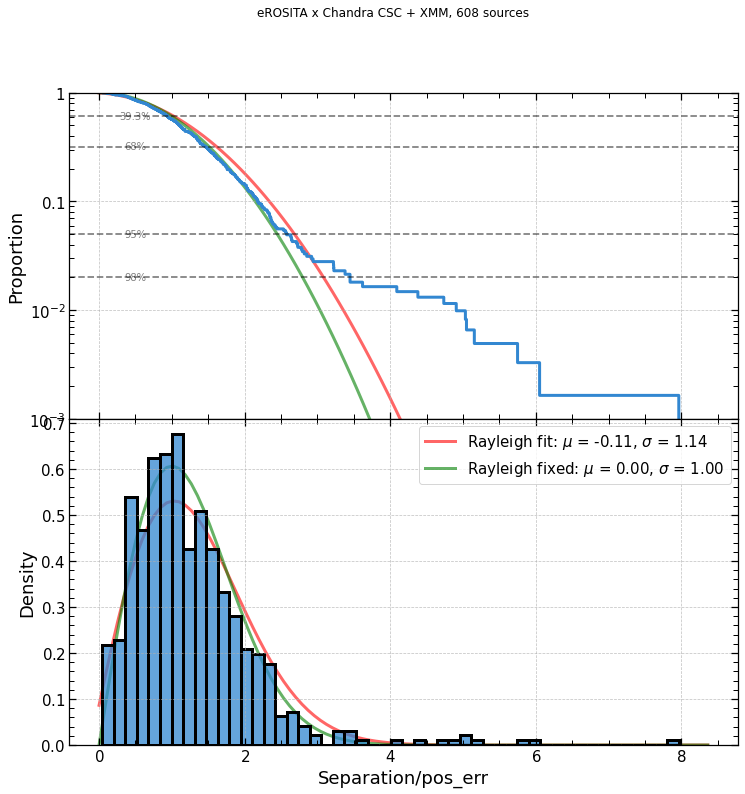

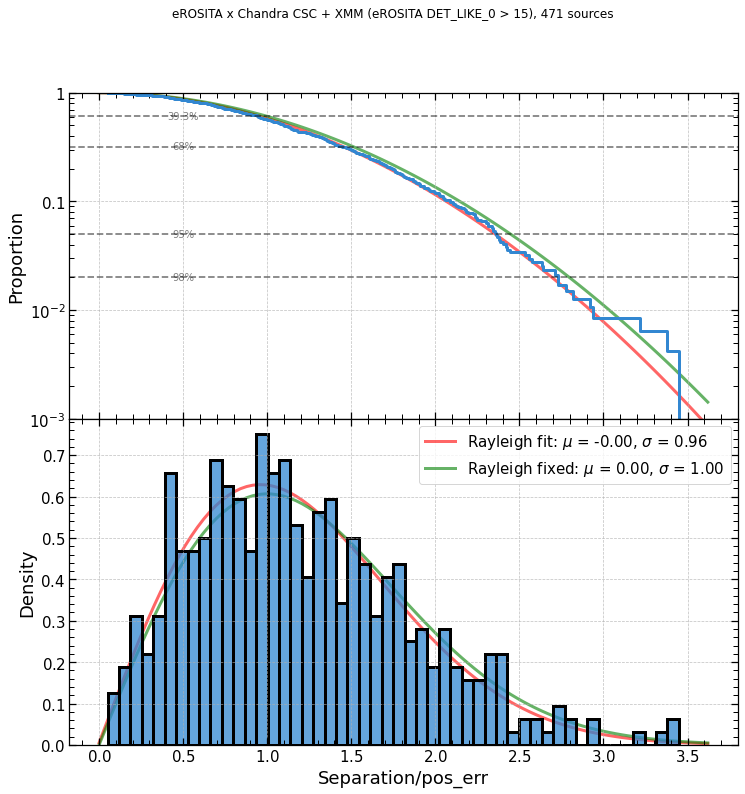

In [159]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps.query('DET_LIKE_0>15'), sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM (eROSITA DET_LIKE_0 > 15)')



## distribution over separations

[ 5.87694681e+02 -7.10523232e-01  2.59251363e+00  3.04217615e-02]
Number of false companions 27.379585309260904


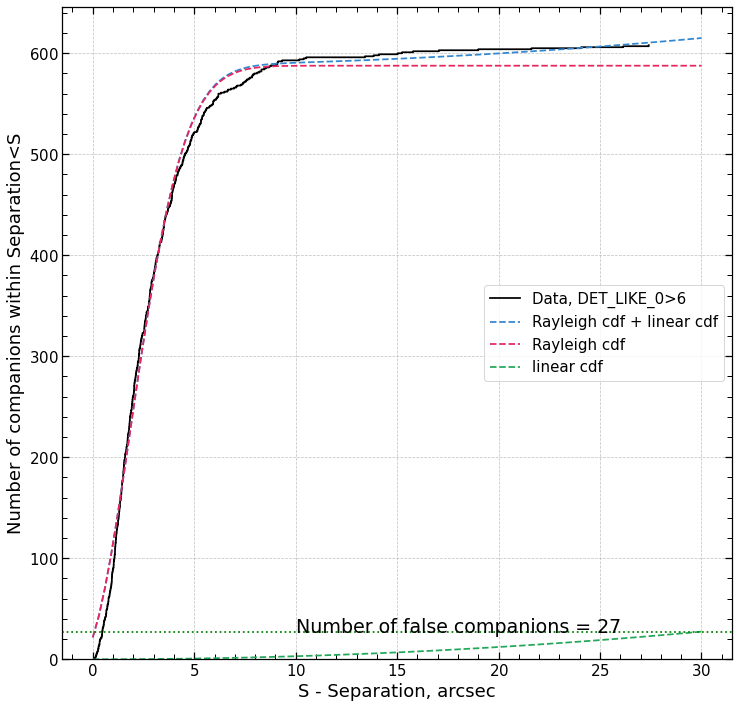

In [188]:
query = 'DET_LIKE_0>6'
seps = final_ctps.query(query)['sep_ero_desi']

sep_bins = np.linspace(0, 30, 300)

sep_hist, bin_edges = np.histogram(seps, bins=sep_bins)
sep_hist = np.cumsum(sep_hist)
hist_area = sep_hist
sep_axis = (bin_edges[1:] + bin_edges[:-1])/2
fig,  ax =  plt.subplots( figsize = (12,12))

#ax.bar(sep_axis, hist_area, width = 1, alpha = 0.4)
sns.ecdfplot(seps, color='k', ax = ax, stat='count', log_scale=False, label = 'Data, '+query )
ax.set_xlabel('S - Separation, arcsec')
ax.set_ylabel('Number of companions within Separation<S')


from scipy.optimize import curve_fit
from scipy import stats
def gaus_cdf(x,N,sep0,sep_sigma):
    #return N*stats.norm.cdf(x, loc=sep0, scale=sep_sigma)
    return N*stats.rayleigh.cdf(x, loc=sep0, scale=sep_sigma)

def linear_cdf(x,a):
    #b = -60*a
    #return a*x**2+b*x
    return a*x**2

def model_cdf(x, N, sep0, sep_sigma, a):
    return gaus_cdf(x,N,sep0,sep_sigma) + linear_cdf(x,a)


#[4.65170706e+03 3.51493202e+00 2.14801955e+00 9.63700566e+00]
popt, pcov = curve_fit(model_cdf, sep_axis, hist_area, p0=[4.6e3, 3, 2,  0])
print(popt)
x = np.linspace(0, 30, 100)
ax.plot(x, model_cdf(x, *popt), 'C0--', label = 'Rayleigh cdf + linear cdf')
ax.plot(x, gaus_cdf(x, *popt[:3]), 'C1--', label = 'Rayleigh cdf')
ax.plot(x, linear_cdf(x, *popt[3:]), 'C2--', label = 'linear cdf')
ax.legend()
n_false  =linear_cdf(30, *popt[3:])
ax.axhline(n_false, color='g', linestyle=':')
ax.text(10, n_false+n_false/2, 'Number of false companions = {:.0f}'.format(n_false),  va='top', ha='left', fontsize = 19)

print('Number of false companions', n_false)
